# Emotion Detection

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import cv2
import random
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator #for understanding of image
from tensorflow.keras.layers import Dense, Input, Dropout, Conv2D, Flatten
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf

C:\Users\Shuaib\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print(tf.__version__)

2.15.0


**Exploring Dataset**

In [3]:
images = glob("/kaggle/input/fer2013/train/**/**")
for i in range(1,10):
    image = random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(3,3,i)
    img = cv2.imread(image)
    plt.imshow(img)
    plt.axis("off")

IndexError: list index out of range

**Preparing Data**

In [6]:
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator(horizontal_flip=True)
training_generator = datagen_train.flow_from_directory("/kaggle/input/fer2013/train/",
                                                      target_size = (img_size,img_size),
                                                      batch_size = batch_size,
                                                      color_mode = "grayscale",
                                                      class_mode = "categorical",
                                                      shuffle = True)

datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_validation.flow_from_directory("/kaggle/input/fer2013/test/",
                                                        target_size = (img_size,img_size),
                                                        color_mode = "grayscale",
                                                        batch_size = batch_size,
                                                        class_mode = "categorical",
                                                        shuffle = True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


**Defining Model**

In [7]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x) #activation function
    x = MaxPooling2D(pool_size=(2,2))(x) #reduce dimensions
    x = Dropout(0.25)(x) #overcome overfitting
    return x


In [8]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.25)(x)
    return x

In [9]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs, 64, (3,3))
    conv_2 = Convolution(conv_1, 128, (5,5))
    conv_3 = Convolution(conv_2, 512, (3,3))
    conv_4 = Convolution(conv_3, 512, (3,3))
    flatten = Flatten()(conv_4)
    dense_1 = Dense_f(flatten, 256)
    dense_2 = Dense_f(dense_1,512)
    
    output = Dense(7, activation = "softmax")(dense_2)
    model = Model(inputs = [inputs], outputs = [output])
    opt = Adam(lr=0.0005)
    model.compile(loss = ["categorical_crossentropy"], optimizer = opt, metrics = ["accuracy"])
    
    return model

In [10]:
model = model_fer((48,48,1))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0     

**Initializing the model**

In [12]:
epochs = 15
steps_per_epoch = training_generator.n//training_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size
checkpoint = ModelCheckpoint("model_weights.h5", monitor = "val_accuracy", save_weights_only = True, mode = "max", verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001)
callbacks = [checkpoint,reduce_lr]

# Training the Model

In [13]:
history = model.fit(
x = training_generator,
steps_per_epoch = steps_per_epoch,
epochs = epochs,
validation_data = validation_generator,
validation_steps = validation_steps,
callbacks = callbacks)

Epoch 1/15


2024-01-01 19:51:06.765253: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


448/448 [==============================] - ETA: 0s - loss: 1.7654 - accuracy: 0.3203
Epoch 1: saving model to model_weights.h5
448/448 [==============================] - 171s 349ms/step - loss: 1.7654 - accuracy: 0.3203 - val_loss: 1.5934 - val_accuracy: 0.4238 - lr: 0.0010
Epoch 2/15
448/448 [==============================] - ETA: 0s - loss: 1.3978 - accuracy: 0.4667
Epoch 2: saving model to model_weights.h5
448/448 [==============================] - 30s 67ms/step - loss: 1.3978 - accuracy: 0.4667 - val_loss: 1.3025 - val_accuracy: 0.4932 - lr: 0.0010
Epoch 3/15
448/448 [==============================] - ETA: 0s - loss: 1.2616 - accuracy: 0.5197
Epoch 3: saving model to model_weights.h5
448/448 [==============================] - 29s 66ms/step - loss: 1.2616 - accuracy: 0.5197 - val_loss: 1.1938 - val_accuracy: 0.5449 - lr: 0.0010
Epoch 4/15
448/448 [==============================] - ETA: 0s - loss: 1.1927 - accuracy: 0.5447
Epoch 4: saving model to model_weights.h5
448/448 [==========

**Model Evaluation**

In [14]:
model.evaluate(validation_generator)

113/113 [==============================] - 6s 53ms/step - loss: 0.9833 - accuracy: 0.6388


[0.9833338856697083, 0.6387572884559631]

**Plotting Loss**

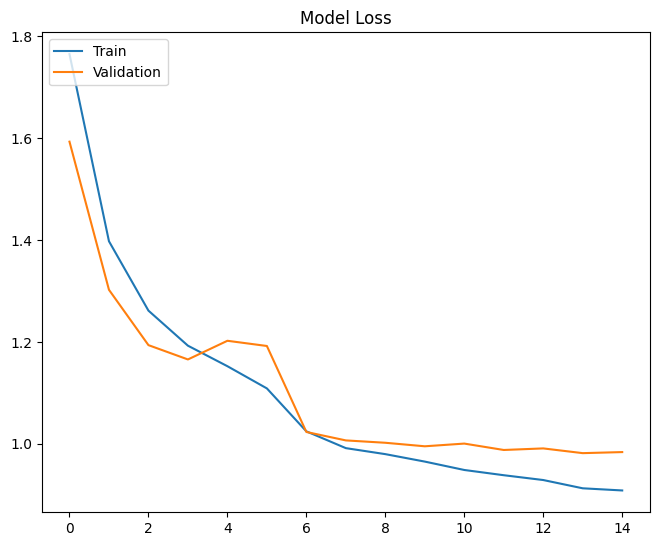

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'], loc='upper left')
plt.subplots_adjust(top=1.0, bottom=0.0, right=0.95, left=0.0, hspace=0.25, wspace=0.35)

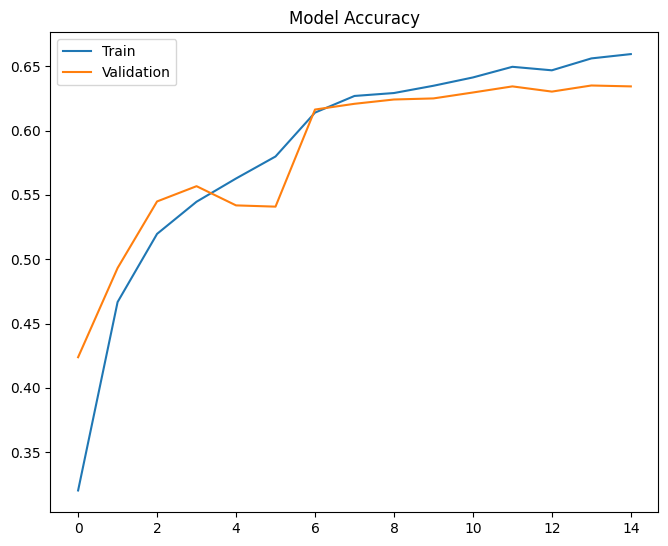

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.0, bottom=0.0, right=0.95, left=0.0, hspace=0.25, wspace=0.35)

**Saving Model**

In [17]:
model_json = model.to_json()
with open('model_a.json',"w") as json_file:
    json_file.write(model_json)